In [1]:
import torch 
import torch.nn as nn
import matplotlib.pylab as plt
import numpy as np
import os
import cv2
import random
import pickle
from tensorflow import keras


In [22]:
#Creating the dataset
DATADIR = "E:\\jupyter ip project\\Images 3\\Images 3"
CATEGORIES = ['RBC', 'WBC']
IMAGE_SIZE = 32
data = []

class my_set():
        def create_train():
                for category in CATEGORIES:
                    path = os.path.join(DATADIR, category)  
                    class_num = CATEGORIES.index(category)
                    for img in os.listdir(path):
                        try:
                          img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                          new_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
                          data.append([new_array, class_num])
                        except:
                            pass
        
        create_train()
        random.shuffle(data)
        
        x = []
        y = []
        
        for features, label in data:
            x.append(features)
            y.append(label)
        
        x = np.array(x).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
        
        pickle_out = open("x.pickle", "wb")
        pickle.dump(x, pickle_out)
        pickle_out.close()
        
        pickle_out = open("y.pickle", "wb")
        pickle.dump(y, pickle_out)
        pickle_out.close()

print("Length of dataset:", len(data))

Length of dataset: 503


In [23]:
#Function to plot the image and model class (CNN)
def show_data(data_sample):
    plt.imshow(data_sample[0].reshape(32, 32), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))
    
    
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=32, out_2=64):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, stride=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 5 * 5, 2)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    


In [52]:
#Creating model instance and other parameters for training
model = CNN()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-5)
train_set, val_set =  torch.utils.data.random_split(data, [399,104 ])
train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = 100)
validation_loader = torch.utils.data.DataLoader(dataset = val_set, batch_size=1)
n_epochs = 5
cost_list = []
accuracy_list = []
N_test = len(val_set)
COST = 0
print("Length of training set: ", len(train_set))
print("Length of validation set: ", len(val_set))

Length of training set:  399
Length of validation set:  104


Validation Accuracy:  92.3076923076923 %


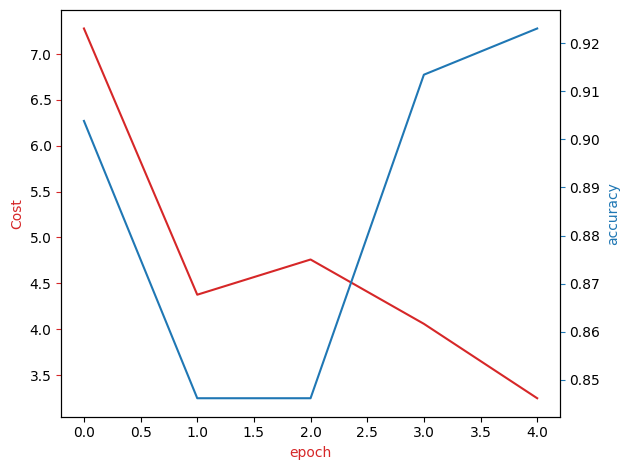

In [53]:
#Training function 
def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.unsqueeze(dim=1).float())
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test.unsqueeze(dim=1).float())
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost_list, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot(accuracy_list, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()
     
    print("Validation Accuracy: ", accuracy*100, "%")

train_model(n_epochs)

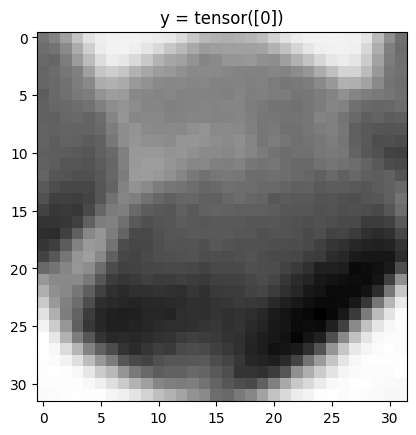

yhat: tensor([0])


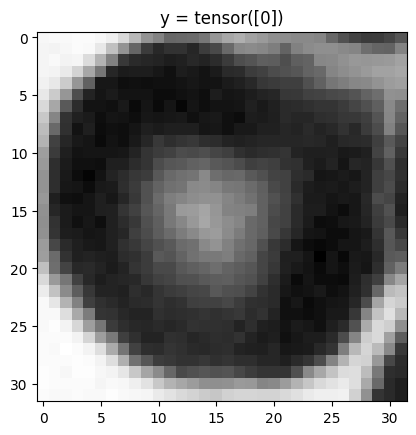

yhat: tensor([0])


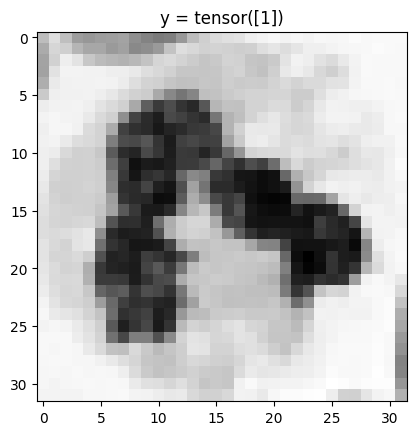

yhat: tensor([1])


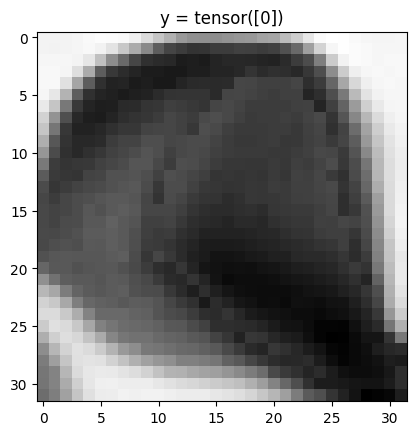

yhat: tensor([0])


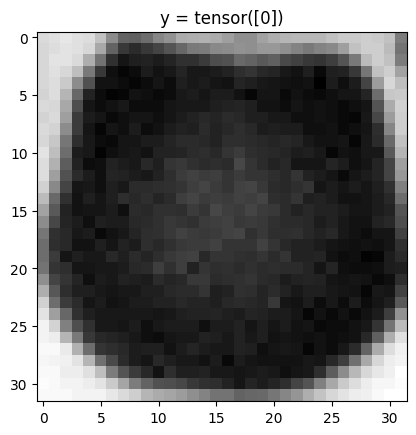

yhat: tensor([0])


In [54]:
#Plotting sample pictures with the outputs
correct=0
count=0
for x_test, y_test in validation_loader:
            z = model(x_test.unsqueeze(dim=1).float())
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            if count < 5:
                show_data((x_test, y_test))
                plt.show()
                print("yhat:", yhat)
                count+=1